In [1]:
from glob import glob
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from pyeit.mesh.wrapper import PyEITAnomaly_Circle
from src.betaVAE_model import vae_model
from src.lstm_mapper3D_model import mapper3D_model
from src.classes import Boundary, TankProperties32x2, BallAnomaly
from src.util import (
    seq_data, 
    load_exp_data3D,
    voxel_ball, 
    plot_voxel_c
)
from pyeit import mesh
from keras import backend as K
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras.models import Model
from tqdm import tqdm

os.environ["CUDA_VISIBLE_DEVICES"] = "1"
from sklearn.decomposition import PCA

2025-02-06 08:12:30.823395: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738829551.072172  820121 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738829551.112667  820121 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-06 08:12:31.725022: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
W0000 00:00:1738829564.654777  820121 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libr

## Load Data

In [2]:
def plot_pca(V, angle, title, n_components=2, figsize=(10,8)):
    
    fig, ax = plt.subplots(figsize=figsize)
    original_shape = V.shape
    V_reshaped = V.reshape(V.shape[0], -1)
    pca = PCA(n_components=n_components)
    V_pca = pca.fit_transform(V_reshaped)

    angle_normalized = (angle - np.min(angle)) / (np.max(angle) - np.min(angle))
    
    scatter = ax.scatter(V_pca[:, 0], V_pca[:, 1], c=angle_normalized, cmap='viridis')
    ax.set_title(title)
    
    ax.set_title(title)
    ax.set_xlabel('Hauptkomponente 1 (PC1)')
    ax.set_ylabel('Hauptkomponente 2 (PC2)')
    ax.set_aspect('equal') 
    
    return fig, pca

def transform_position(position):
    
    # Zentriere nur x und y basierend auf erstem Punkt
    center_offset = np.array([position[0,0], position[0,1], 0])  # Z-Offset ist 0
    position_centered = position - center_offset
    
    # Skalierungsfaktoren
    scale_factor = 32/194 #für x,y 
    scale_z = 24/140 #für z
    
    position_centered[:,0] = position_centered[:,0] * scale_factor
    position_centered[:,1] = position_centered[:,1] * scale_z
    position_centered[:,2] = position_centered[:,2] * scale_z

    # x und y um (16,16) zentrieren und Höhe auf 8 angepasst (zentriert um die mittelere Höhe des Tanks)
    position_centered[:,0] = position_centered[:,0] + 16
    position_centered[:,1] = position_centered[:,1] + 16
    position_centered[:,2] = position_centered[:,2] + 8
    
    return position_centered[1:]

def create_gamma(position):
    boundary = Boundary()
    gamma = list()
    diameter_labels = list()
    pos_ball = list()
    vol_ball = list()

    perm = 1
    d = 7

    for i, (x, y, z) in enumerate(position):
        ball = BallAnomaly(x, y, z, d, perm) 
        vxl_ball = voxel_ball(ball, boundary)
                
        gamma.append(vxl_ball)
        diameter_labels.append(d)  
        pos_ball.append([ball.y, ball.x, ball.z])
        vol_ball.append(np.where(vxl_ball == 1)[0].shape[0])

    gamma = np.array(gamma) / 2
    diameter_labels = np.array(diameter_labels)
    pos_ball = np.array(pos_ball)
    vol_ball = np.array(vol_ball)

    return gamma, diameter_labels, pos_ball, vol_ball

def load_3Ddata(file_name, use_mean= False):
    
    print("Loading experimental data...")
    voltage, _, _, position = load_exp_data3D(file_name)
    
    voltage_abs = np.abs(voltage) #absolutwert berechnen
    #fig, pca_fitted = plot_pca(voltage[:,1,:,:], position, "PCA der Spannungsdaten")
    #plt.show()
    
    #z-score normalization
    voltage_normalized = (voltage_abs - np.mean(voltage_abs)) / np.std(voltage_abs)

    voltage_diff = voltage_normalized - voltage_normalized[0] #substraktion von ersten messung (leere Tankmessung)
    voltage_diff = voltage_diff[1:]  # erste Messung "wegwerfen"

    #use mean oder alle Messungen (burst counts) einzeln
    if use_mean:
        print("Calculating mean of voltage differences...")
        voltage_diff = np.mean(voltage_diff, axis=1)
    
    # Transformiere Positionsdaten (d.h. auf 32x32x32 Raum anpassen)
    print("Transforming position data...")
    trans_pos = transform_position(position)
    
    # Erstelle Gamma
    print("Creating gamma...")
    gamma, _, _, _ = create_gamma(trans_pos)
    
    if use_mean:
        print("Processing sequences with mean...")
        voltage_seq, gamma_seq = seq_data(voltage_diff, gamma, n_seg=4)
    else:
        print("Processing sequences for each measurement...")
        voltage_sequences = []
        gamma_sequences = []
        
        for idx in tqdm(range(5), desc="Processing measurement sequences"):
            v_seq, g_seq = seq_data(voltage_diff[:, idx, :, :], gamma, n_seg=4)
            voltage_sequences.append(v_seq)
            gamma_sequences.append(g_seq)
            
        print("Concatenating sequences...")
        voltage_seq = np.concatenate(voltage_sequences, axis=0)
        gamma_seq = np.concatenate(gamma_sequences, axis=0)
    
    print("Data loading complete!")
    return voltage_seq, gamma_seq

In [3]:
voltage, gamma = load_3Ddata("exp_data_3D18")

Loading experimental data...
Transforming position data...
Creating gamma...
Processing sequences for each measurement...


Processing measurement sequences: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


Concatenating sequences...
Data loading complete!


In [4]:
print(voltage.shape)

(55980, 4, 64, 64)


In [5]:
print(gamma.shape)

(55980, 32, 32, 32)


In [74]:
# Angenommen, wir haben 5 burst counts und wollen die ersten 4 für Training
total_samples = voltage.shape[0]
burst_size = total_samples // 5  # Größe eines burst counts
train_bursts = 4  # Anzahl der burst counts für Training

# Split basierend auf burst counts
voltage_train = voltage[:burst_size * train_bursts]
voltage_test = voltage[burst_size * train_bursts:]
gamma_train = gamma[:burst_size * train_bursts]
gamma_test = gamma[burst_size * train_bursts:]

# Überprüfung
print(f"Samples pro burst count: {burst_size}")
print(f"Voltage Train: {voltage_train.shape} ({train_bursts} bursts)")
print(f"Voltage Test: {voltage_test.shape} (1 burst)")
print(f"Gamma train: {gamma_train.shape}")
print(f"Gamma test: {gamma_test.shape}")

Samples pro burst count: 11196
Voltage Train: (44784, 4, 64, 64) (4 bursts)
Voltage Test: (11196, 4, 64, 64) (1 burst)
Gamma train: (44784, 32, 32, 32)
Gamma test: (11196, 32, 32, 32)


## Loading VAE Model and generating labels

In [75]:
beta =  1.04
vae = vae_model(input_shape=(32, 32, 32, 1), filters=[1, 4, 8, 16], beta=beta)
vae.build(input_shape=(32, 32, 32, 1))
vae.load_weights("weights/3Dvae_best.weights.h5")
print("Gewichte erfolgreich geladen.")

Gewichte erfolgreich geladen.


In [76]:
_, _, latent_rep = vae.encoder.predict(gamma_train)

1400/1400 ━━━━━━━━━━━━━━━━━━━━ 44s 31ms/step


Original...


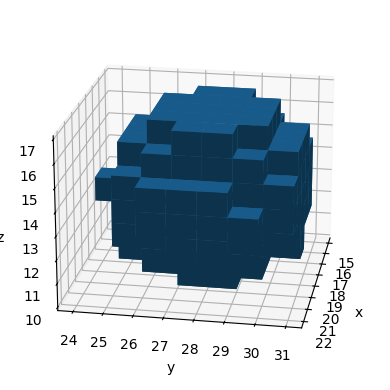

Prediction...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


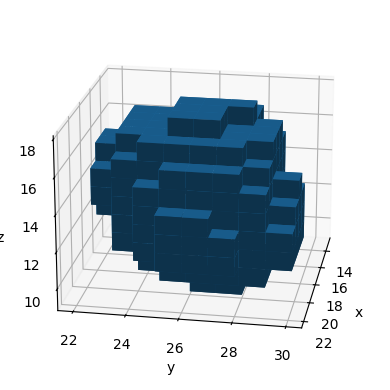

Original...


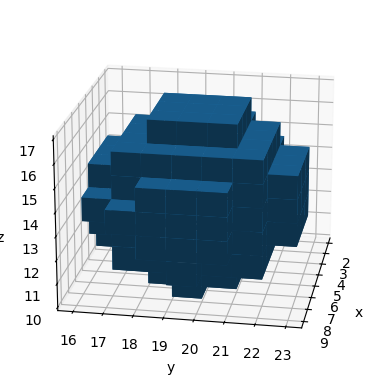

Prediction...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


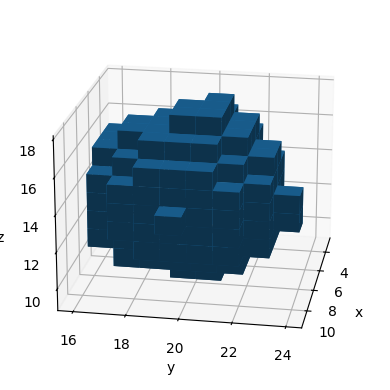

Original...


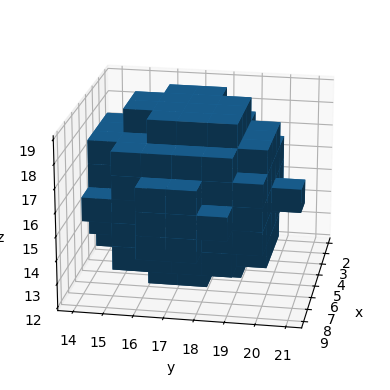

Prediction...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


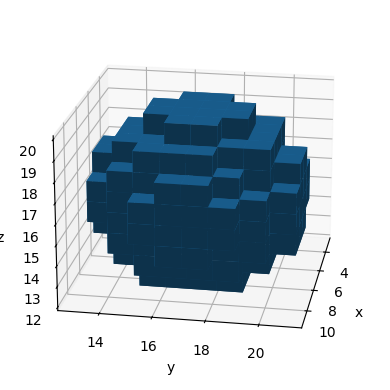

Original...


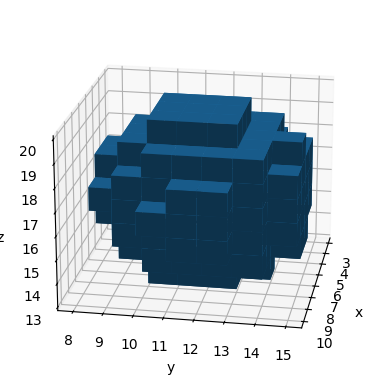

Prediction...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


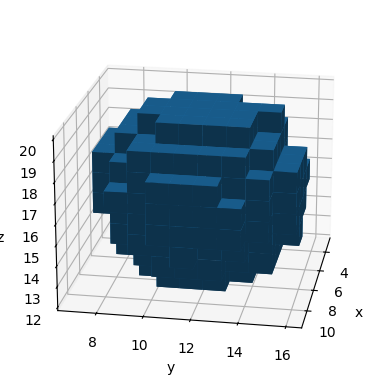

Original...


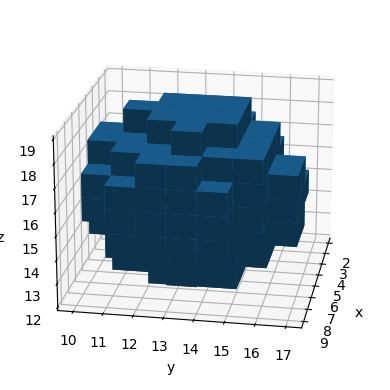

Prediction...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


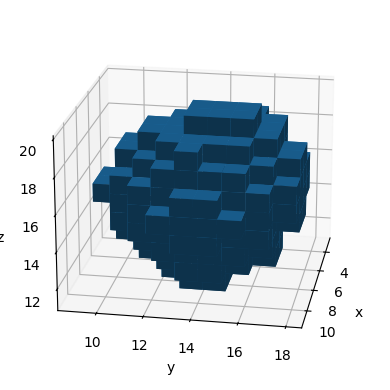

In [77]:
#Test, ob der VAE auch tut was er tun soll...
plt.style.use("default")
for rdn in np.random.randint(low=0, high=gamma.shape[0], size=5):
    print("Original...")
    plot_voxel_c(gamma[rdn, ...])

    print("Prediction...")
    _, _, z = vae.encoder.predict(np.expand_dims(gamma[rdn, ...], 0))
    sgl_pred = vae.decoder.predict(z)
    sgl_pred = np.squeeze(sgl_pred, axis=4)
    sgl_pred = np.squeeze(sgl_pred, axis=0)
    sgl_pred = np.clip(sgl_pred, a_min=0, a_max=1)
    plot_voxel_c(sgl_pred)

## LSTM Mapper Training

In [78]:
 _, _, z = vae.encoder.predict(np.expand_dims(gamma[1, ...], 0))
sgl_pred = vae.decoder.predict(z)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


In [22]:
z.shape

(1, 8)

In [79]:
(
    v_train_seq,
    v_test_seq,
    g_train,
    g_train,
    z_train,
    z_test,
) = train_test_split(
    voltage_train,
    gamma_train,
    latent_rep,
    test_size=0.1,
    shuffle=True,
    random_state=42,
)

In [80]:
print(v_train_seq.shape)

(40305, 4, 64, 64)


In [81]:
lstm_mapper = mapper3D_model()
lstm_mapper.summary()
lstm_mapper.compile(optimizer="adam", loss="mse")

Model: "lstm_mapper"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 4, 64, 64, 1)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_8              │ (None, 4, 31, 31, 2)   │            20 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_9              │ (None, 4, 15, 15, 2)   │            38 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_10             │ (None, 4, 450)         │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_11             │ (None, 4, 64)          │        28,864 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 4, 32)          │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 8)              │           136 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,610 (174.26 KB)

 Trainable params: 44,610 (174.26 KB)

 Non-trainable params: 0 (0.00 B)

In [82]:
history_mapper = lstm_mapper.fit(v_train_seq, z_train, epochs=100, batch_size = 8, validation_split = 0.1)

Epoch 1/100
4535/4535 ━━━━━━━━━━━━━━━━━━━━ 52s 11ms/step - loss: 0.0199 - val_loss: 0.0012
Epoch 2/100
4535/4535 ━━━━━━━━━━━━━━━━━━━━ 48s 11ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 3/100
4535/4535 ━━━━━━━━━━━━━━━━━━━━ 49s 11ms/step - loss: 0.0010 - val_loss: 9.6537e-04
Epoch 4/100
4535/4535 ━━━━━━━━━━━━━━━━━━━━ 49s 11ms/step - loss: 9.8168e-04 - val_loss: 9.8170e-04
Epoch 5/100
4535/4535 ━━━━━━━━━━━━━━━━━━━━ 47s 10ms/step - loss: 9.5097e-04 - val_loss: 9.0392e-04
Epoch 6/100
4535/4535 ━━━━━━━━━━━━━━━━━━━━ 49s 11ms/step - loss: 9.2884e-04 - val_loss: 9.4594e-04
Epoch 7/100
4535/4535 ━━━━━━━━━━━━━━━━━━━━ 47s 10ms/step - loss: 9.1444e-04 - val_loss: 9.0453e-04
Epoch 8/100
4535/4535 ━━━━━━━━━━━━━━━━━━━━ 47s 10ms/step - loss: 8.9528e-04 - val_loss: 8.7987e-04
Epoch 9/100
4535/4535 ━━━━━━━━━━━━━━━━━━━━ 48s 11ms/step - loss: 8.8414e-04 - val_loss: 8.5524e-04
Epoch 10/100
4535/4535 ━━━━━━━━━━━━━━━━━━━━ 47s 10ms/step - loss: 8.8268e-04 - val_loss: 8.8497e-04
Epoch 11/100
4535/4535 ━━━━━━

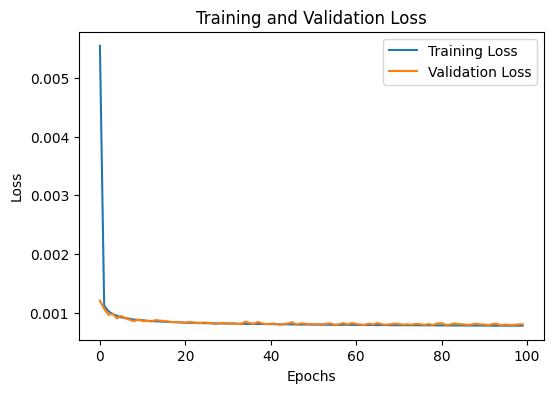

In [83]:
plt.figure(figsize=(6, 4))
plt.plot(history_mapper.history["loss"], label="Training Loss")
plt.plot(history_mapper.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


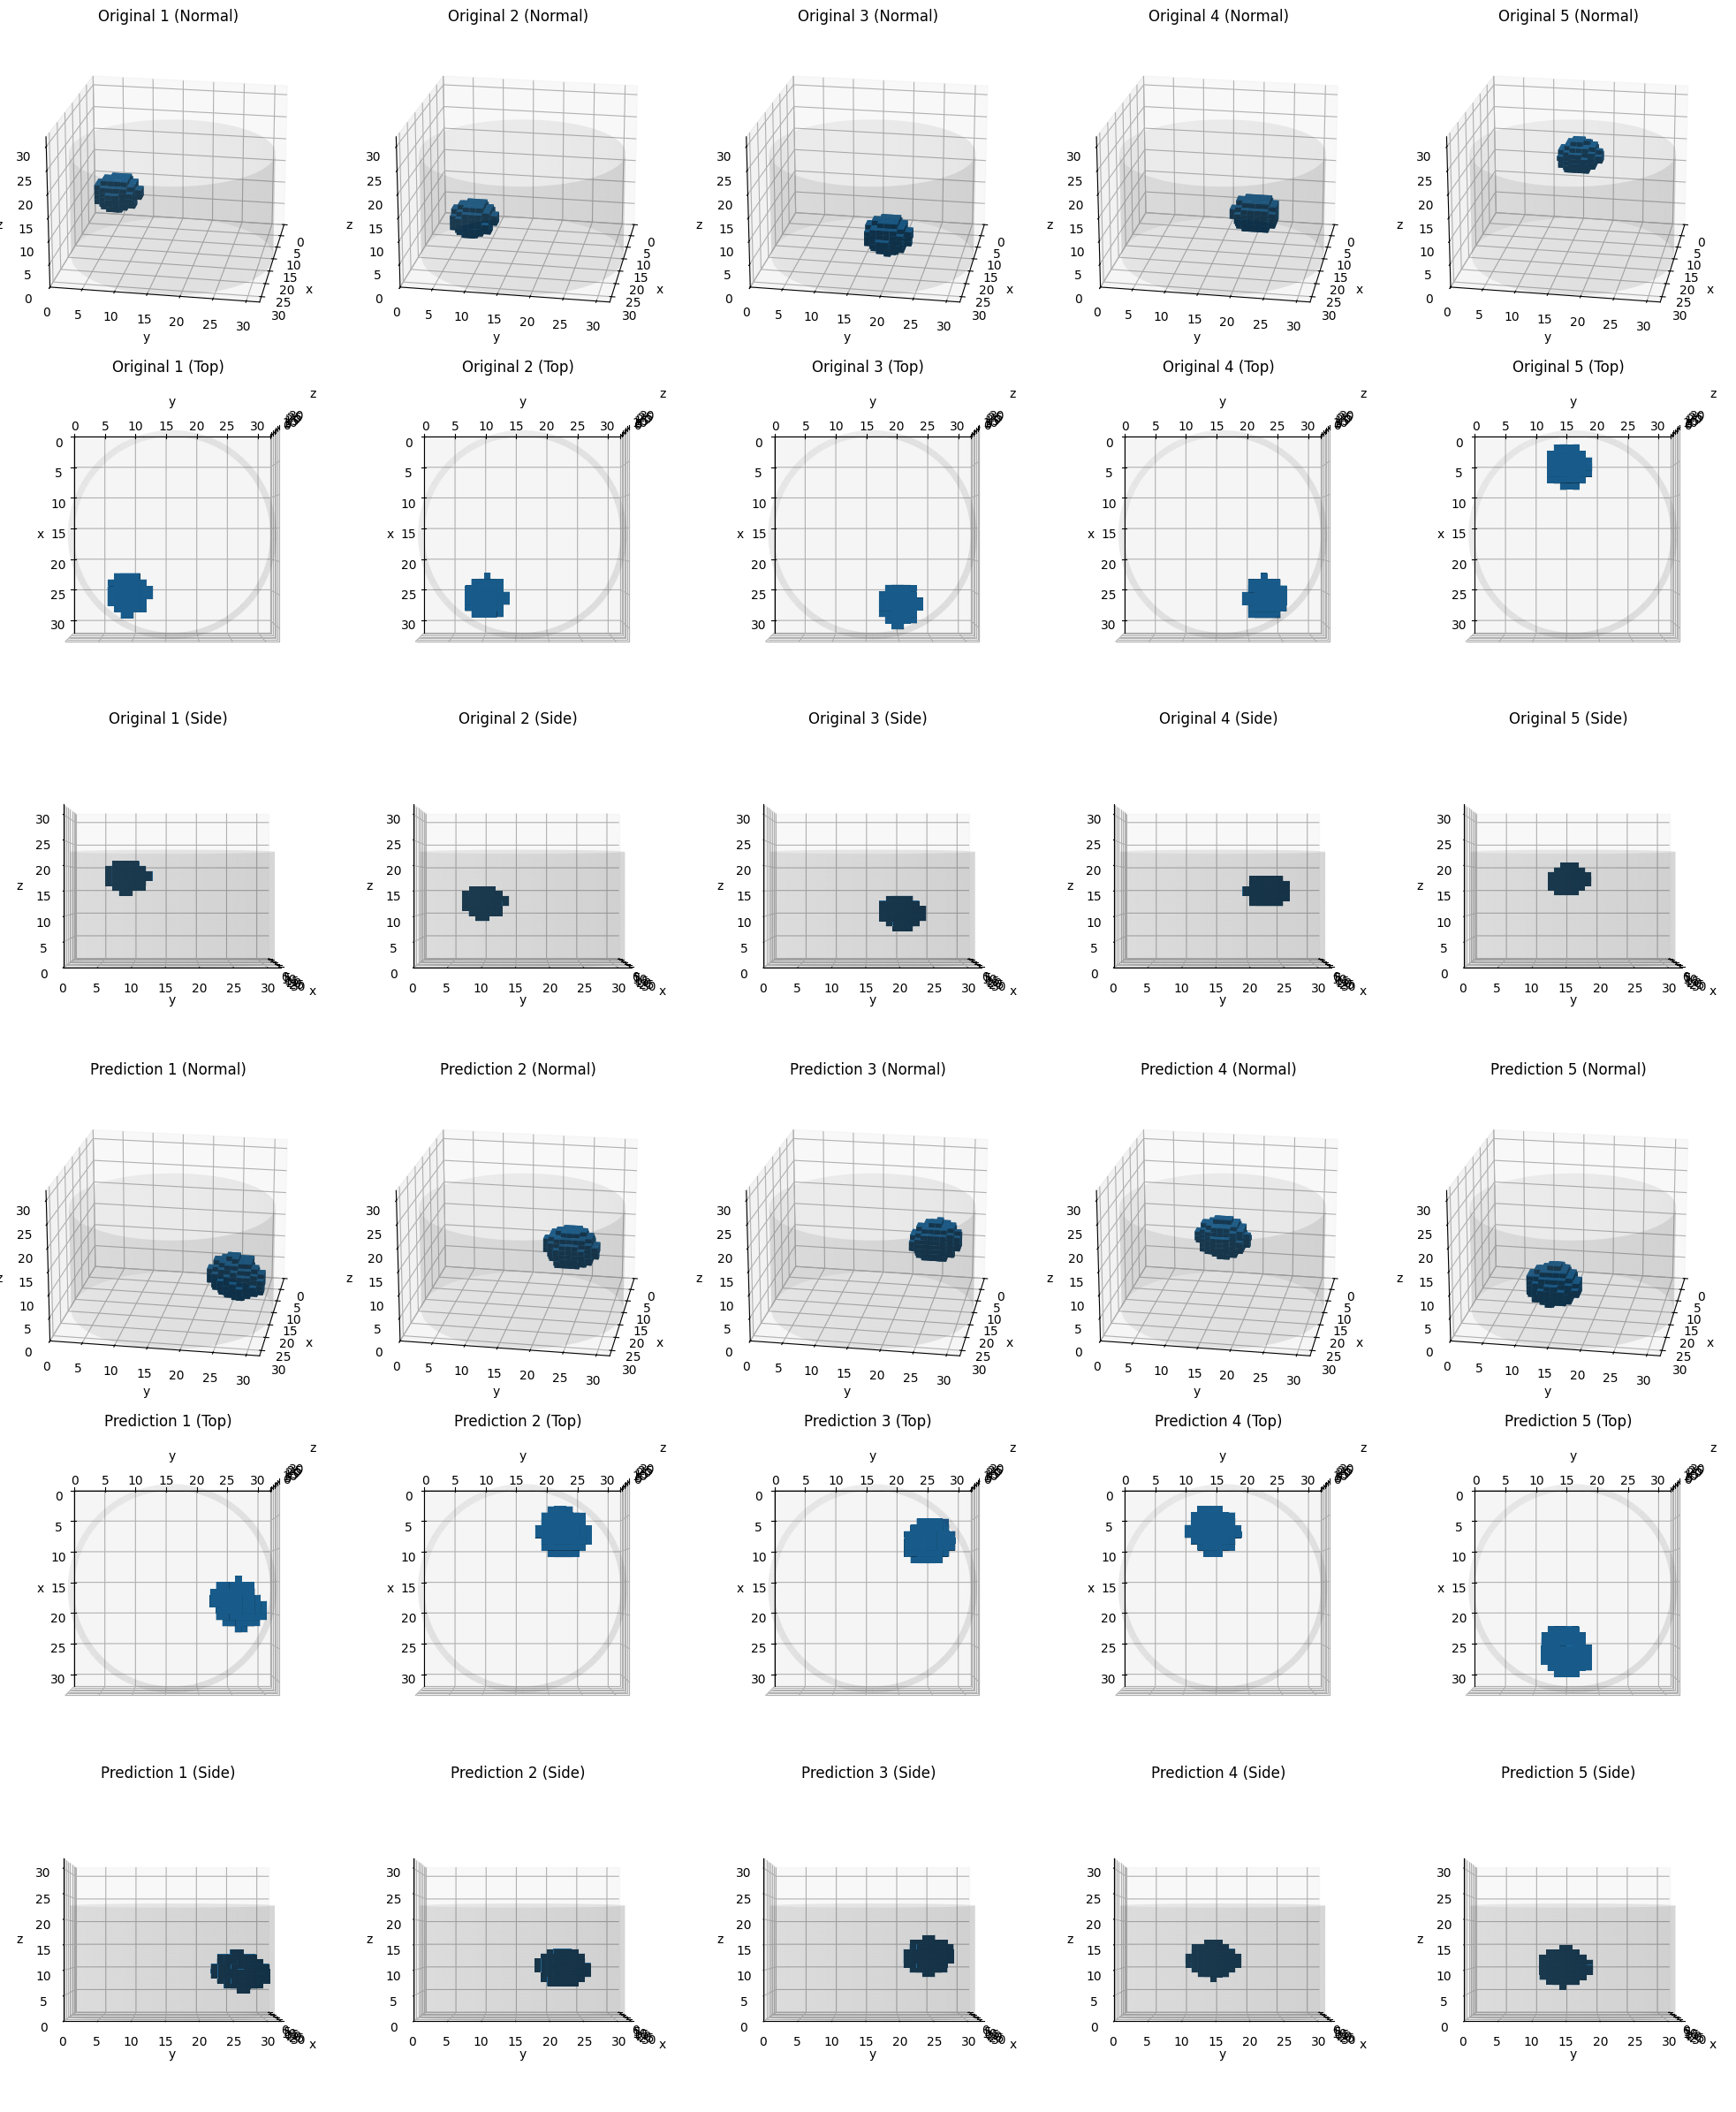

In [84]:
def create_cylinder_mesh(n_points=100): 
    tank = TankProperties32x2()
    scale_factor = 32 / tank.T_d 
    cylinder_radius = tank.T_r * scale_factor
    cylinder_height = tank.T_bz[1] * scale_factor

    theta = np.linspace(0, 2*np.pi, n_points)
    z = np.linspace(0, cylinder_height, n_points)
    theta, z = np.meshgrid(theta, z)
    x = cylinder_radius * np.cos(theta)
    y = cylinder_radius * np.sin(theta)
    x += 16  
    y += 16  

    return x, y, z

def plot_voxel_comparisons(originals, predictions, normal_elev=20, normal_azim=10):
    """
    Plot originals and predictions with normal view, top view, and side view
    """
    colors = ["C0", "C1"]
    n_samples = len(originals)
    
    x_cyl, y_cyl, z_cyl = create_cylinder_mesh()
    
    # 6 Reihen: je 3 Ansichten für Original und Prediction
    fig = plt.figure(figsize=(4*n_samples, 24))
    
    # Normale Ansicht Originals (erste Reihe)
    for i in range(n_samples):
        ax = fig.add_subplot(6, n_samples, i+1, projection='3d')
        ax.plot_surface(x_cyl, y_cyl, z_cyl, alpha=0.1, color='gray')
        ax.voxels(
            originals[i].transpose(1, 0, 2),
            facecolors=colors[int(np.max(originals[i]) - 1)]
        )
        ax.set_xlim(0, 32)
        ax.set_ylim(0, 32)
        ax.set_zlim(0, 32)
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_zlabel("z")
        ax.view_init(azim=normal_azim, elev=normal_elev)
        ax.set_title(f"Original {i+1} (Normal)")

    # Draufsicht Originals (zweite Reihe)
    for i in range(n_samples):
        ax = fig.add_subplot(6, n_samples, n_samples+i+1, projection='3d')
        ax.plot_surface(x_cyl, y_cyl, z_cyl, alpha=0.1, color='gray')
        ax.voxels(
            originals[i].transpose(1, 0, 2),
            facecolors=colors[int(np.max(originals[i]) - 1)]
        )
        ax.set_xlim(0, 32)
        ax.set_ylim(0, 32)
        ax.set_zlim(0, 32)
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_zlabel("z")
        ax.view_init(azim=0, elev=90)  # Draufsicht
        ax.set_title(f"Original {i+1} (Top)")

    # Seitenansicht Originals (dritte Reihe)
    for i in range(n_samples):
        ax = fig.add_subplot(6, n_samples, 2*n_samples+i+1, projection='3d')
        ax.plot_surface(x_cyl, y_cyl, z_cyl, alpha=0.1, color='gray')
        ax.voxels(
            originals[i].transpose(1, 0, 2),
            facecolors=colors[int(np.max(originals[i]) - 1)]
        )
        ax.set_xlim(0, 32)
        ax.set_ylim(0, 32)
        ax.set_zlim(0, 32)
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_zlabel("z")
        ax.view_init(azim=0, elev=0)  # Seitenansicht
        ax.set_title(f"Original {i+1} (Side)")

    # Normale Ansicht Predictions (vierte Reihe)
    for i in range(n_samples):
        ax = fig.add_subplot(6, n_samples, 3*n_samples+i+1, projection='3d')
        ax.plot_surface(x_cyl, y_cyl, z_cyl, alpha=0.1, color='gray')
        ax.voxels(
            predictions[i].transpose(1, 0, 2),
            facecolors=colors[int(np.max(predictions[i]) - 1)]
        )
        ax.set_xlim(0, 32)
        ax.set_ylim(0, 32)
        ax.set_zlim(0, 32)
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_zlabel("z")
        ax.view_init(azim=normal_azim, elev=normal_elev)
        ax.set_title(f"Prediction {i+1} (Normal)")

    # Draufsicht Predictions (fünfte Reihe)
    for i in range(n_samples):
        ax = fig.add_subplot(6, n_samples, 4*n_samples+i+1, projection='3d')
        ax.plot_surface(x_cyl, y_cyl, z_cyl, alpha=0.1, color='gray')
        ax.voxels(
            predictions[i].transpose(1, 0, 2),
            facecolors=colors[int(np.max(predictions[i]) - 1)]
        )
        ax.set_xlim(0, 32)
        ax.set_ylim(0, 32)
        ax.set_zlim(0, 32)
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_zlabel("z")
        ax.view_init(azim=0, elev=90)  # Draufsicht
        ax.set_title(f"Prediction {i+1} (Top)")

    # Seitenansicht Predictions (sechste Reihe)
    for i in range(n_samples):
        ax = fig.add_subplot(6, n_samples, 5*n_samples+i+1, projection='3d')
        ax.plot_surface(x_cyl, y_cyl, z_cyl, alpha=0.1, color='gray')
        ax.voxels(
            predictions[i].transpose(1, 0, 2),
            facecolors=colors[int(np.max(predictions[i]) - 1)]
        )
        ax.set_xlim(0, 32)
        ax.set_ylim(0, 32)
        ax.set_zlim(0, 32)
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_zlabel("z")
        ax.view_init(azim=0, elev=0)  # Seitenansicht
        ax.set_title(f"Prediction {i+1} (Side)")
    
    plt.tight_layout()
    plt.show()

# Hauptcode bleibt gleich
plt.style.use("default")
random_indices = np.random.randint(low=0, high=gamma_test.shape[0], size=5)
originals = []
predictions = []
for rdn in random_indices:
    originals.append(gamma_test[rdn, ...])
    pred_latent = lstm_mapper.predict(voltage_test[rdn:rdn+1])
    gamma_pred = vae.decoder.predict(pred_latent)
    gamma_pred = np.squeeze(gamma_pred, axis=4)
    gamma_pred = np.squeeze(gamma_pred, axis=0)
    gamma_pred = np.clip(gamma_pred, a_min=0, a_max=1)
    predictions.append(gamma_pred)
plot_voxel_comparisons(originals, predictions)

In [49]:
def center_of_mass(voxel_matrix):
    x_coords, y_coords, z_coords = np.meshgrid(
        np.arange(voxel_matrix.shape[0]),
        np.arange(voxel_matrix.shape[1]),
        np.arange(voxel_matrix.shape[2]),
    )
    total_mass = np.sum(voxel_matrix)
    center_x = np.sum(x_coords * voxel_matrix) / total_mass
    center_y = np.sum(y_coords * voxel_matrix) / total_mass
    center_z = np.sum(z_coords * voxel_matrix) / total_mass

    return np.array([center_y, center_x, center_z])


In [51]:
gamma_test.shape

(4479, 32, 32, 32)

In [53]:
centers = np.array([center_of_mass(gamma_test[i]) for i in range(gamma_test.shape[0])])


In [54]:
centers.shape

(4479, 3)

In [72]:
gamma_test.shape

(11196, 32, 32, 32)

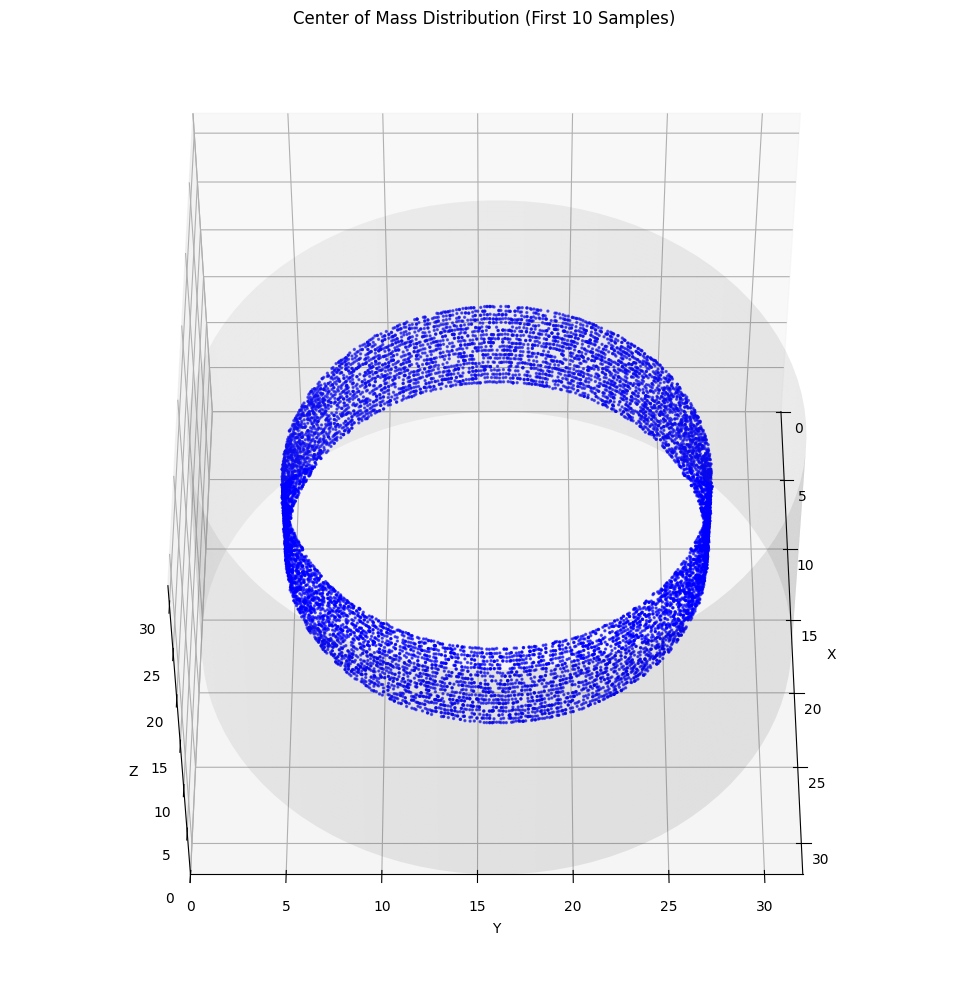

Koordinaten der ersten 10 Schwerpunkte:
Sample 0: (x=23.97, y=24.12, z=13.15)
Sample 1: (x=22.37, y=25.33, z=17.87)
Sample 2: (x=4.43, y=14.61, z=16.87)
Sample 3: (x=17.22, y=27.14, z=12.73)
Sample 4: (x=4.86, y=19.26, z=14.34)
Sample 5: (x=14.27, y=4.94, z=9.96)
Sample 6: (x=5.76, y=21.32, z=18.22)
Sample 7: (x=10.28, y=25.72, z=16.53)
Sample 8: (x=12.50, y=26.71, z=15.71)
Sample 9: (x=8.49, y=7.44, z=13.77)
Sample 10: (x=27.40, y=13.81, z=17.13)
Sample 11: (x=7.02, y=8.88, z=10.00)
Sample 12: (x=17.74, y=27.09, z=10.58)
Sample 13: (x=4.63, y=13.70, z=15.61)
Sample 14: (x=7.43, y=8.44, z=17.69)
Sample 15: (x=21.29, y=26.00, z=16.16)
Sample 16: (x=24.79, y=23.31, z=12.31)
Sample 17: (x=25.57, y=9.62, z=11.16)
Sample 18: (x=4.62, y=13.69, z=14.31)
Sample 19: (x=4.53, y=14.06, z=14.29)
Sample 20: (x=11.48, y=26.32, z=13.99)
Sample 21: (x=12.00, y=5.50, z=12.50)
Sample 22: (x=19.78, y=26.59, z=14.04)
Sample 23: (x=10.45, y=25.85, z=13.14)
Sample 24: (x=18.24, y=5.02, z=14.61)
Sample 25: (

In [85]:
# Berechne Schwerpunkte
centers = np.array([center_of_mass(gamma_train[i]) for i in range(11196)])  # nur erste 10

# Erstelle 3D Plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Plotte Schwerpunkte
scatter = ax.scatter(centers[:, 0], 
                    centers[:, 1], 
                    centers[:, 2],
                    c='blue',
                    s= 2,
                    alpha=0.6)

# Tank-Zylinder hinzufügen für Kontext
x_cyl, y_cyl, z_cyl = create_cylinder_mesh()
ax.plot_surface(x_cyl, y_cyl, z_cyl, alpha=0.1, color='gray')

# Achsen-Beschriftungen
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Center of Mass Distribution (First 10 Samples)')

# Achsen-Grenzen
ax.set_xlim(0, 32)
ax.set_ylim(0, 32)
ax.set_zlim(0, 32)
ax.view_init(azim=0, elev=50)
plt.tight_layout()
plt.show()

# Optional: Ausgabe der genauen Koordinaten
print("Koordinaten der ersten 10 Schwerpunkte:")
for i, center in enumerate(centers):
    print(f"Sample {i}: (x={center[0]:.2f}, y={center[1]:.2f}, z={center[2]:.2f})")